<a href="https://colab.research.google.com/github/nopynospy/apu_deep_learning/blob/main/LAB_7_Transfer_Learning_finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries

In [1]:
import keras
import os, shutil
import pandas as pd

In [3]:
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from keras import optimizers

In [4]:
vgg_model = VGG16(include_top=False,
              weights='imagenet',
              input_shape=(224,224,3),
              pooling=None)

58900480/58889256 [==============================] - 1s 0us/step


Unlike in base model, where all vgg layers were set to trainable False, only layer 4 and 5 vgg layers are set as trainable.

In [ ]:
vgg_model.trainable = True

set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])       

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.In...,input_1,False
1,<tensorflow.python.keras.layers.convolutional....,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional....,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPoo...,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional....,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional....,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPoo...,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional....,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional....,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional....,block3_conv3,False


In [5]:
import keras
# Instantiate the sequential model and add the VGG16 model: 
model = keras.models.Sequential()
model.add(vgg_model)

In [6]:
# Add the custom layers atop the VGG19 model: 
model.add(Flatten(name='flattened'))
model.add(Dropout(0.5, name='dropout1'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3, name='dropout2'))
model.add(Dense(1, activation='sigmoid', name='predictions'))

In [8]:
from tensorflow.keras import optimizers
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flattened (Flatten)         (None, 25088)             0         
                                                                 
 dropout1 (Dropout)          (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout2 (Dropout)          (None, 512)               0         
                                                                 
 predictions (Dense)         (None, 1)                 513       
                                                                 
Total params: 27,560,769
Trainable params: 27,560,769
No

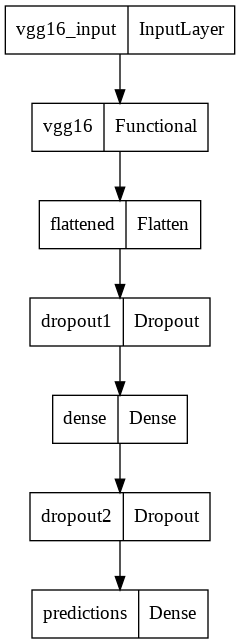

In [10]:
plot_model(model)

In [11]:
# mount drive first
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
# Provide path to the dataset
base_dir = '/content/drive/MyDrive/DataGenerator/cats_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [13]:
# Preparing the data
# Batch size depends on the datset size. 
# In this example there are 2000 image in training set and 1000 in test set.
# Both are divisible by 20. Hence batch size is chosen as 20

from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory (train_dir, )
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 224x224
        target_size=(224, 224),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 1010 images belonging to 2 classes.


In [14]:
# steps_per_epoch is based on the number of batches available in the training dataset
# validation_steps is based on the number of batches in the validation dataset

history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 480s 4s/step - loss: 0.7423 - accuracy: 0.5375 - val_loss: 0.6289 - val_accuracy: 0.6740
Epoch 2/30
100/100 [==============================] - 92s 916ms/step - loss: 0.6521 - accuracy: 0.6340 - val_loss: 0.5797 - val_accuracy: 0.7170
Epoch 3/30
100/100 [==============================] - 92s 917ms/step - loss: 0.4658 - accuracy: 0.7810 - val_loss: 0.3663 - val_accuracy: 0.8410
Epoch 4/30
100/100 [==============================] - 92s 917ms/step - loss: 0.3533 - accuracy: 0.8535 - val_loss: 0.3930 - val_accuracy: 0.8500
Epoch 5/30
100/100 [==============================] - 92s 916ms/step - loss: 0.2576 - accuracy: 0.8980 - val_loss: 0.3176 - val_accuracy: 0.8600
Epoch 6/30
100/100 [==============================] - 92s 916ms/step - loss: 0.2073 - accuracy: 0.9305 - val_loss: 0.2516 - val_accuracy: 0.9020
Epoch 7/30
100/100 [==============================] - 92s 917ms/step - loss: 0.1596 - accuracy: 0.9420 - val_loss: 0.6598 - val_accu

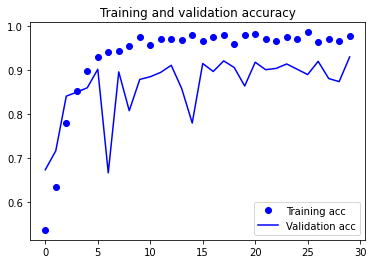

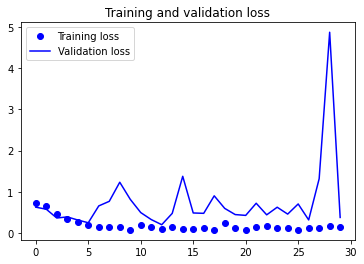

In [15]:
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

At epoch 30, these are the results: loss: 0.1396 - accuracy: 0.9785 - val_loss: 0.3802 - val_accuracy: 0.9300. Compared to when all VGG layers were frozen and at the same model.fit, the maximum validation accuracy achieved was not more than 0.91. Thus, only training layers 4 and 5 is better than freezing all layers.

In [16]:
model.save('lab_7_finetune_tl.h5')

from google.colab import files
files.download('lab_7_finetune_tl.h5')
# model.save('/content/drive/My Drive/Colab Notebooks/Teaching/finetune_transfer_learning_VGG16_cats.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Testing the performance of training 1 vgg layer

Since animal images, including cats and dogs, are very frequently used for computer vision in general, VGG might also have been trained on similar images.

In [20]:
vgg_model2 = VGG16(include_top=False,
              weights='imagenet',
              input_shape=(224,224,3),
              pooling=None)

In [21]:
vgg_model2.trainable = True

set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model2.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])  

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_3,True
1,<keras.layers.convolutional.Conv2D object at 0...,block1_conv1,True
2,<keras.layers.convolutional.Conv2D object at 0...,block1_conv2,True
3,<keras.layers.pooling.MaxPooling2D object at 0...,block1_pool,True
4,<keras.layers.convolutional.Conv2D object at 0...,block2_conv1,True
5,<keras.layers.convolutional.Conv2D object at 0...,block2_conv2,True
6,<keras.layers.pooling.MaxPooling2D object at 0...,block2_pool,True
7,<keras.layers.convolutional.Conv2D object at 0...,block3_conv1,True
8,<keras.layers.convolutional.Conv2D object at 0...,block3_conv2,True
9,<keras.layers.convolutional.Conv2D object at 0...,block3_conv3,True


In [22]:
import keras
# Instantiate the sequential model and add the VGG16 model: 
model2 = keras.models.Sequential()
model2.add(vgg_model2)

In [23]:
# Add the custom layers atop the VGG19 model: 
model2.add(Flatten(name='flattened'))
model2.add(Dropout(0.5, name='dropout1'))
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.3, name='dropout2'))
model2.add(Dense(1, activation='sigmoid', name='predictions'))

In [24]:
from tensorflow.keras import optimizers
model2.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

In [25]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flattened (Flatten)         (None, 25088)             0         
                                                                 
 dropout1 (Dropout)          (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 512)               12845568  
                                                                 
 dropout2 (Dropout)          (None, 512)               0         
                                                                 
 predictions (Dense)         (None, 1)                 513       
                                                                 
Total params: 27,560,769
Trainable params: 27,560,769


In [26]:
history = model2.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 94s 918ms/step - loss: 0.7267 - accuracy: 0.5050 - val_loss: 0.7064 - val_accuracy: 0.4980
Epoch 2/30
100/100 [==============================] - 91s 915ms/step - loss: 0.7136 - accuracy: 0.5390 - val_loss: 0.5849 - val_accuracy: 0.6740
Epoch 3/30
100/100 [==============================] - 92s 915ms/step - loss: 0.6123 - accuracy: 0.6755 - val_loss: 0.4687 - val_accuracy: 0.7780
Epoch 4/30
100/100 [==============================] - 91s 915ms/step - loss: 0.4475 - accuracy: 0.7930 - val_loss: 0.3610 - val_accuracy: 0.8430
Epoch 5/30
100/100 [==============================] - 92s 915ms/step - loss: 0.3400 - accuracy: 0.8635 - val_loss: 0.2422 - val_accuracy: 0.8970
Epoch 6/30
100/100 [==============================] - 92s 915ms/step - loss: 0.2448 - accuracy: 0.9125 - val_loss: 0.2757 - val_accuracy: 0.8760
Epoch 7/30
100/100 [==============================] - 92s 915ms/step - loss: 0.1916 - accuracy: 0.9240 - val_loss: 0.3963 - val_ac

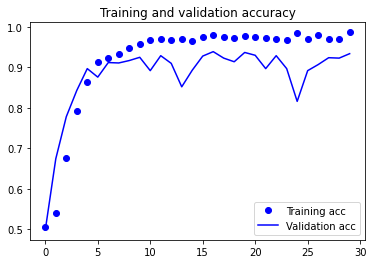

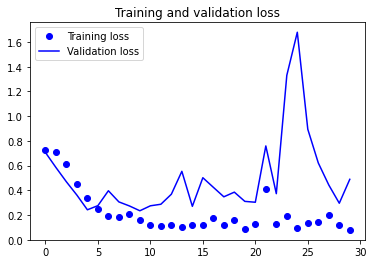

In [27]:
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [28]:
model.save('lab_7_finetune_tl_2.h5')

from google.colab import files
files.download('lab_7_finetune_tl_2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

At epoch 20, the result was loss: 0.0876 - accuracy: 0.9770 - val_loss: 0.3104 - val_accuracy: 0.9370. This is better than the loss: 0.1396 - accuracy: 0.9785 - val_loss: 0.3802 - val_accuracy: 0.9300 in the previous model, where VGG layers 4 and 5 were trained. Thus, when trained on only layer 5, the result is better than no layer trained and layer 4 and 5 trained.